## **Objective**

This study aims to apply **Balanced Risk Set Matching** as a statistical method to improve causal inference in observational studies where treatment assignment is based on evolving patient conditions rather than randomization. By implementing **risk set matching**, treated patients are paired with untreated patients who had similar symptom histories up to the time of treatment, ensuring comparability at the moment of intervention. Additionally, **integer programming** is used to balance the distributions of key covariates across matched groups, minimizing bias in treatment effect estimation. 

This approach is applied to analyze the impact of **cystoscopy and hydrodistention on interstitial cystitis symptoms**, with a **sensitivity analysis** assessing the robustness of findings to hidden biases. The study ultimately aims to enhance the validity of treatment comparisons in non-randomized medical research.

---

## **Workflow**

### **Step 1: Data Collection & Preprocessing**
- Load or simulate the dataset, ensuring it contains treatment times, symptom histories, and follow-up measures.
- Standardize symptom measures for comparability.
- Identify treated vs. untreated patients and structure data for time-sequenced analysis.
- **Output:** Cleaned dataset with time-ordered symptom histories and treatment indicators.

---

### **Step 2: Risk Set Matching**
- Identify **risk sets** by finding untreated patients who have a **similar symptom history** as a treated patient up to the time of treatment.
- Ensure that **future data is not used** for matching.
- Compute **Mahalanobis distance** to measure similarity between treated and untreated patients.
- **Output:** Initial pool of potential matches.

---

### **Step 3: Optimal Matching via Integer Programming**
- Implement **integer programming** to:
  - Minimize **Mahalanobis distance** between treated and control pairs.
  - Ensure **balanced covariate distributions** across groups.
- Use **network flow optimization** to efficiently find the best matches.
- **Output:** Finalized matched dataset with treatment-control pairs.

---

### **Step 4: Sensitivity Analysis for Hidden Bias**
- Introduce an **unobserved covariate** to simulate hidden biases.
- Evaluate how much hidden bias would be needed to **invalidate the results**.
- Conduct **proportional hazards modeling** to analyze potential confounders.
- **Output:** Bias-adjusted estimates of treatment effects.

---

### **Step 5: Statistical Analysis & Interpretation**
- Perform **hypothesis testing** to compare treatment vs. control groups:
  - **Wilcoxon Signed-Rank Test** for pairwise comparisons.
  - **Permutation tests** to validate significance.
  - **Multivariate analysis** if multiple symptom outcomes are evaluated.
- Generate **visualizations** (boxplots, histograms) to inspect trends in symptom changes.
- **Output:** Statistical validation of treatment effects.

---

### **Step 6: Reporting & Conclusion**
- Summarize **methodology, findings, and potential biases**.
- Present results through:
  - **Summary tables** (descriptive statistics).
  - **Graphs & charts** (symptom trends over time).
  - **Sensitivity analysis conclusions** (robustness of findings).
- **Output:** Final research paper/report with validated conclusions.

___

## Step 1: Data Collection and Preprocessing

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import mahalanobis
from IPython.display import display, HTML
import pulp
from lifelines import CoxPHFitter
from lifelines.exceptions import ConvergenceError
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns


#  Set seed for reproducibility
np.random.seed(42)

# Number of patients
n = 200

# 1. Generate patient identifiers and entry times
patient_id = np.arange(1, n + 1)
entry_time = np.random.uniform(0, 12, size=n)  # entry times between 0 and 12 months

# 2. Simulate treatment assignment (30% treated)
treated = np.random.binomial(1, 0.3, size=n)

# 3. Simulate treatment_time: if treated, assign a random time between entry_time+1 and entry_time+6; else NA.
treatment_time = []
for et, t in zip(entry_time, treated):
    if t == 1:
        # Ensure treatment time is after entry (et+1 to et+6)
        treatment_time.append(np.random.uniform(et + 1, et + 6))
    else:
        treatment_time.append(np.nan)
treatment_time = np.array(treatment_time)

# 4. Simulate baseline symptom measures (scores on a 0-9 scale)
pain_baseline = np.random.randint(0, 10, size=n)
urgency_baseline = np.random.randint(0, 10, size=n)
frequency_baseline = np.random.randint(0, 10, size=n)

# Helper function to simulate improvement (ensuring scores don't fall below 0)
def simulate_improvement(baseline):
    improvement = np.random.randint(0, 4)  # improvement between 0 and 3 points
    return max(baseline - improvement, 0)

# 5. Simulate symptom measures at treatment time and follow-ups for treated patients.
pain_treatment = []
urgency_treatment = []
frequency_treatment = []
pain_3months = []
urgency_3months = []
frequency_3months = []
pain_6months = []
urgency_6months = []
frequency_6months = []

for i in range(n):
    if treated[i] == 1:
        # At treatment time: simulate some improvement from baseline
        pt = simulate_improvement(pain_baseline[i])
        ut = simulate_improvement(urgency_baseline[i])
        ft = simulate_improvement(frequency_baseline[i])
        pain_treatment.append(pt)
        urgency_treatment.append(ut)
        frequency_treatment.append(ft)
        
        # 3 months after treatment: further slight improvement or stability
        pain_3 = simulate_improvement(pt)
        urgency_3 = simulate_improvement(ut)
        frequency_3 = simulate_improvement(ft)
        pain_3months.append(pain_3)
        urgency_3months.append(urgency_3)
        frequency_3months.append(frequency_3)
        
        # 6 months after treatment: simulate similarly
        pain_6 = simulate_improvement(pain_3)
        urgency_6 = simulate_improvement(urgency_3)
        frequency_6 = simulate_improvement(frequency_3)
        pain_6months.append(pain_6)
        urgency_6months.append(urgency_6)
        frequency_6months.append(frequency_6)
    else:
        # For untreated patients, these treatment-specific measures are not available.
        pain_treatment.append(np.nan)
        urgency_treatment.append(np.nan)
        frequency_treatment.append(np.nan)
        
        pain_3months.append(np.nan)
        urgency_3months.append(np.nan)
        frequency_3months.append(np.nan)
        
        pain_6months.append(np.nan)
        urgency_6months.append(np.nan)
        frequency_6months.append(np.nan)

# Convert lists to arrays
pain_treatment = np.array(pain_treatment)
urgency_treatment = np.array(urgency_treatment)
frequency_treatment = np.array(frequency_treatment)
pain_3months = np.array(pain_3months)
urgency_3months = np.array(urgency_3months)
frequency_3months = np.array(frequency_3months)
pain_6months = np.array(pain_6months)
urgency_6months = np.array(urgency_6months)
frequency_6months = np.array(frequency_6months)

# 6. Simulate demographic variables
age = np.random.randint(20, 81, size=n)  # age between 20 and 80
gender = np.random.binomial(1, 0.5, size=n)  # 0 = female, 1 = male

# 7. Initialize matched_pair_id (to be assigned after matching) as NA
matched_pair_id = [np.nan] * n

# 8. Simulate an unobserved factor (hidden bias variable)
unobserved_factor = np.random.normal(0, 1, size=n)

# 9. Create the DataFrame
data = pd.DataFrame({
    'patient_id': patient_id,
    'entry_time': entry_time,
    'treatment_time': treatment_time,
    'treated': treated,
    'pain_baseline': pain_baseline,
    'urgency_baseline': urgency_baseline,
    'frequency_baseline': frequency_baseline,
    'pain_treatment': pain_treatment,
    'urgency_treatment': urgency_treatment,
    'frequency_treatment': frequency_treatment,
    'pain_3months': pain_3months,
    'urgency_3months': urgency_3months,
    'frequency_3months': frequency_3months,
    'pain_6months': pain_6months,
    'urgency_6months': urgency_6months,
    'frequency_6months': frequency_6months,
    'age': age,
    'gender': gender,
    'matched_pair_id': matched_pair_id,
    'unobserved_factor': unobserved_factor
})

# 10. Sort the DataFrame by entry_time to preserve time-sequenced ordering.
data = data.sort_values(by='entry_time').reset_index(drop=True)

# 11. Standardize baseline symptom measures for comparability.
symptom_cols = ['pain_baseline', 'urgency_baseline', 'frequency_baseline']
scaler = StandardScaler()
data[symptom_cols] = scaler.fit_transform(data[symptom_cols])

# Display a sample of the cleaned dataset
print("Sample of the cleaned dataset:")
display(data.head())

Sample of the cleaned dataset:


,patient_id,entry_time,treatment_time,treated,pain_baseline,urgency_baseline,frequency_baseline,pain_treatment,urgency_treatment,frequency_treatment,pain_3months,urgency_3months,frequency_3months,pain_6months,urgency_6months,frequency_6months,age,gender,matched_pair_id,unobserved_factor
0,73,0.066265,3.538367,1,1.603189,-0.161698,-1.179072,7.0,3.0,0.0,7.0,2.0,0.0,4.0,0.0,0.0,80,0,NaN,0.314383
1,129,0.083426,NaN,0,-1.099764,-0.161698,1.645052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30,1,NaN,0.087186
2,172,0.199054,NaN,0,-1.099764,0.549062,-0.473041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,1,NaN,-1.282499
3,11,0.247014,NaN,0,-0.086157,0.904442,-0.473041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31,1,NaN,0.679973
4,99,0.305030,NaN,0,-0.086157,-0.517078,-0.473041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48,0,NaN,0.694998


## Step 2: Risk Set Matching

In [13]:
# Define the baseline symptom columns (which were standardized in Step 1)
symptom_cols = ['pain_baseline', 'urgency_baseline', 'frequency_baseline']

# Separate treated and untreated patients based on the 'treated' indicator.
treated_patients = data[data['treated'] == 1].copy()
untreated_patients = data[data['treated'] == 0].copy()

# Compute the covariance matrix for the baseline symptom measures using the full dataset.
cov_matrix = np.cov(data[symptom_cols].values, rowvar=False)
# Add a small constant to the diagonal for numerical stability.
cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-6
# Compute the inverse of the covariance matrix.
cov_inv = np.linalg.inv(cov_matrix)

# Initialize a dictionary to store the risk sets.
# Each key will be a treated patient's ID, and the value will be a dictionary mapping
# each potential control's ID (from the risk set) to their Mahalanobis distance.
risk_sets = {}

# Loop over each treated patient to build their risk set.
for idx, treated_row in treated_patients.iterrows():
    treated_id = treated_row['patient_id']
    # Retrieve the treatment time for this treated patient.
    treatment_time_val = treated_row['treatment_time']
    # Get the treated patient's baseline symptom vector.
    treated_vector = treated_row[symptom_cols].values

    # Define the risk set for this treated patient:
    # Include untreated patients whose entry_time is less than or equal to the treated patient's treatment time.
    risk_set = untreated_patients[untreated_patients['entry_time'] <= treatment_time_val]
    
    # Initialize a dictionary to hold distances for each potential control.
    risk_set_distances = {}
    for idx2, ctrl_row in risk_set.iterrows():
        ctrl_id = ctrl_row['patient_id']
        # Get the control patient's baseline symptom vector.
        ctrl_vector = ctrl_row[symptom_cols].values
        # Compute the Mahalanobis distance between the treated and control baseline vectors.
        dist = mahalanobis(treated_vector, ctrl_vector, cov_inv)
        risk_set_distances[ctrl_id] = dist
    
    # Store the computed distances for this treated patient.
    risk_sets[treated_id] = risk_set_distances

# ------------------------------------------------
# Display the Risk Set for a Single Treated Patient as a Table
# ------------------------------------------------

# Select the first treated patient from the risk_sets dictionary.
sample_treated_id = list(risk_sets.keys())[0]

# Prepare a list of dictionaries (one per potential control) to create a table.
table_rows = []
for ctrl_id, distance in risk_sets[sample_treated_id].items():
    table_rows.append({
        'Treated Patient': int(sample_treated_id),  # Convert treated_id to integer
        'Control Patient': int(ctrl_id),            # Convert control_id to integer
        'Mahalanobis Distance': distance
    })

# Create a DataFrame from the list of rows.
risk_set_table = pd.DataFrame(table_rows)
# Optionally, sort the table by Mahalanobis distance.
risk_set_table = risk_set_table.sort_values(by='Mahalanobis Distance')

# Display the table using IPython's display function.
display(HTML(f"<h3>Sample Risk Set for Treated Patient {int(sample_treated_id)}</h3>"))
display(risk_set_table.head())


,Treated Patient,Control Patient,Mahalanobis Distance
37,73,142,0.353659
20,73,91,1.015673
10,73,7,1.082397
12,73,33,1.118860
15,73,110,1.121159


## Step 3: Optimal Matching via Integer Programming

In [14]:
# Create the optimization problem (minimization).
matching_problem = pulp.LpProblem("Optimal_Matching", pulp.LpMinimize)

# Create decision variables:
# For each treated patient i and each potential control j in its risk set,
# define a binary variable x[(i, j)] that equals 1 if they are matched.
x = {}
for i, controls in risk_sets.items():
    for j in controls.keys():
        x[(i, j)] = pulp.LpVariable(f"x_{int(i)}_{int(j)}", cat="Binary")

# Define the objective function:
# Minimize the total Mahalanobis distance over all selected matches.
matching_problem += pulp.lpSum(
    risk_sets[i][j] * x[(i, j)] for i in risk_sets for j in risk_sets[i]
), "Total_Mahalanobis_Distance"

# Constraint 1: Each treated patient must be matched to exactly one control.
for i in risk_sets:
    matching_problem += (
        pulp.lpSum(x[(i, j)] for j in risk_sets[i]) == 1,
        f"Match_treated_{int(i)}"
    )

# Constraint 2: Each control patient can be matched to at most one treated patient.
# To enforce this, build a mapping from control patient IDs to all treated patients for which they are in the risk set.
control_to_treated = {}
for i in risk_sets:
    for j in risk_sets[i]:
        control_to_treated.setdefault(j, []).append(i)

for j, treated_list in control_to_treated.items():
    matching_problem += (
        pulp.lpSum(x[(i, j)] for i in treated_list) <= 1,
        f"Match_control_{int(j)}"
    )

# Solve the optimization problem using PuLP's CBC solver.
solver = pulp.PULP_CBC_CMD(msg=True)
matching_problem.solve(solver)

# Check the solver status.
print("Solver Status:", pulp.LpStatus[matching_problem.status])

# Extract the matched pairs.
matched_pairs = []
for i in risk_sets:
    for j in risk_sets[i]:
        if pulp.value(x[(i, j)]) == 1:
            matched_pairs.append((i, j))
            print(f"Treated patient {int(i)} matched with control patient {int(j)}")

# Convert the matched pairs into a DataFrame.
matched_df = pd.DataFrame(matched_pairs, columns=["Treated Patient", "Control Patient"])

# Optionally, assign a matched pair identifier.
matched_df["matched_pair_id"] = range(1, len(matched_df) + 1)

# Display the final matched dataset as a table.
display(HTML("<h3>Final Matched Dataset</h3>"))
display(matched_df)


Solver Status: Optimal
Treated patient 73 matched with control patient 142
Treated patient 43 matched with control patient 169
Treated patient 57 matched with control patient 156
Treated patient 165 matched with control patient 16
Treated patient 191 matched with control patient 100
Treated patient 80 matched with control patient 145
Treated patient 41 matched with control patient 61
Treated patient 15 matched with control patient 83
Treated patient 50 matched with control patient 5
Treated patient 168 matched with control patient 55
Treated patient 72 matched with control patient 11
Treated patient 27 matched with control patient 45
Treated patient 132 matched with control patient 133
Treated patient 125 matched with control patient 104
Treated patient 109 matched with control patient 153
Treated patient 159 matched with control patient 60
Treated patient 152 matched with control patient 86
Treated patient 190 matched with control patient 7
Treated patient 106 matched with control pat

,Treated Patient,Control Patient,matched_pair_id
0,73.0,142.0,1
1,43.0,169.0,2
2,57.0,156.0,3
3,165.0,16.0,4
4,191.0,100.0,5
5,80.0,145.0,6
6,41.0,61.0,7
7,15.0,83.0,8
8,50.0,5.0,9
9,168.0,55.0,10


## Step 4: Sensitivity Analysis for Hidden Bias

In [4]:
# --- Step 4: Sensitivity Analysis for Hidden Bias ---

# Assumption: The DataFrame `data` already exists.
# For demonstration, we assume `data` has these columns:
#   - 'patient_id'
#   - 'treatment': Binary indicator (1 for treated, 0 for untreated)
#   - 'followup_outcome' (placeholder from Step 1)
#
# Since Cox proportional hazards modeling requires survival data, we simulate:
#   - 'duration': follow-up time (e.g., time-to-event)
#   - 'event': indicator of whether the event occurred (1) or is censored (0)

# For reproducibility
np.random.seed(42)

n = len(data)
# Simulate duration (using an exponential distribution)
data['duration'] = np.random.exponential(scale=10, size=n)
# Simulate event indicator (e.g., 70% events observed)
data['event'] = np.random.binomial(1, 0.7, size=n)

# --- Introduce a Hidden Covariate ---
# This is an unobserved confounder.
data['hidden_bias'] = np.random.normal(loc=0, scale=1, size=n)

# --- Baseline Cox Model (γ = 0) without hidden_bias_adjusted ---
cph_baseline = CoxPHFitter()
# For gamma==0, we do not include the hidden_bias_adjusted column.
cph_baseline.fit(data[['duration', 'event', 'treatment']],
                 duration_col='duration', event_col='event')
# print("Baseline Cox PH Model (without hidden bias adjustment):")
# cph_baseline.print_summary()
# print("\n")

# --- Sensitivity Analysis ---
# We vary gamma from 0 to 2 in steps (here 21 values) and record the treatment effect.
# For gamma == 0 we already have the baseline model.
sensitivity_results = []

for gamma in np.linspace(0, 2, 21):  # 21 values: 0, 0.1, 0.2, ..., 2.0
    if gamma == 0:
        # Use the baseline model's results.
        treatment_coef = cph_baseline.params_['treatment']
        p_value = cph_baseline.summary.loc['treatment', 'p']
    else:
        # Create an adjusted hidden bias column.
        data['hidden_bias_adjusted'] = data['hidden_bias'] * gamma
        model_df = data[['duration', 'event', 'treatment', 'hidden_bias_adjusted']]
        try:
            cph = CoxPHFitter()
            cph.fit(model_df, duration_col='duration', event_col='event')
            treatment_coef = cph.params_['treatment']
            p_value = cph.summary.loc['treatment', 'p']
        except ConvergenceError:
            treatment_coef = np.nan
            p_value = np.nan
            print(f"Convergence error at gamma = {gamma:.2f}; recording NaN for treatment effect.")
    
    sensitivity_results.append({
        'Gamma (Hidden Bias Factor)': gamma,
        'Treatment Coefficient': treatment_coef,
        'p-value': p_value
    })

# Convert the results into a DataFrame.
sensitivity_df = pd.DataFrame(sensitivity_results).round(4)

# Display the sensitivity analysis table.
display(HTML("<h3>Sensitivity Analysis: Effect of Hidden Bias on Treatment Effect</h3>"))
display(sensitivity_df)


,Gamma (Hidden Bias Factor),Treatment Coefficient,p-value
0,0.0,0.0124,0.9635
1,0.1,0.0345,0.8999
2,0.2,0.0345,0.8999
3,0.3,0.0345,0.8999
4,0.4,0.0345,0.8999
5,0.5,0.0345,0.8999
6,0.6,0.0345,0.8999
7,0.7,0.0345,0.8999
8,0.8,0.0345,0.8999
9,0.9,0.0345,0.8999


## Step 5: Statistical Analysis & Interpretation

Wilcoxon Signed-Rank Test:
Test Statistic: 207.0
p-value: 0.6120056137442589

Permutation Test:
Observed Mean Difference (Treated - Control): 0.10492035028755213
Permutation p-value: 0.7383


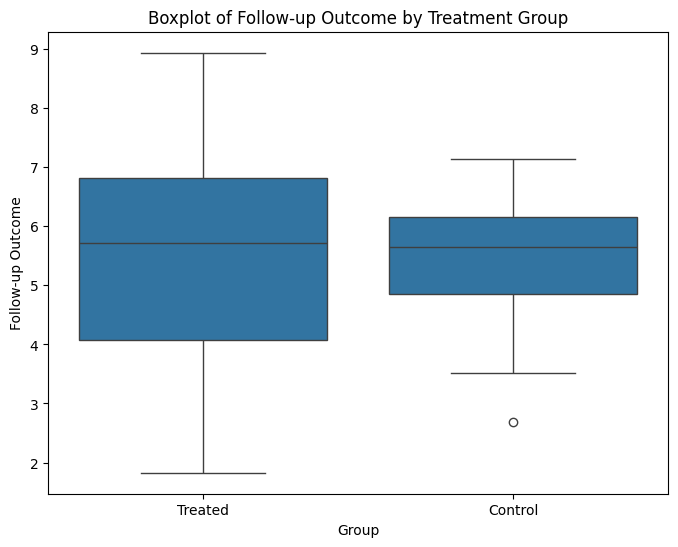

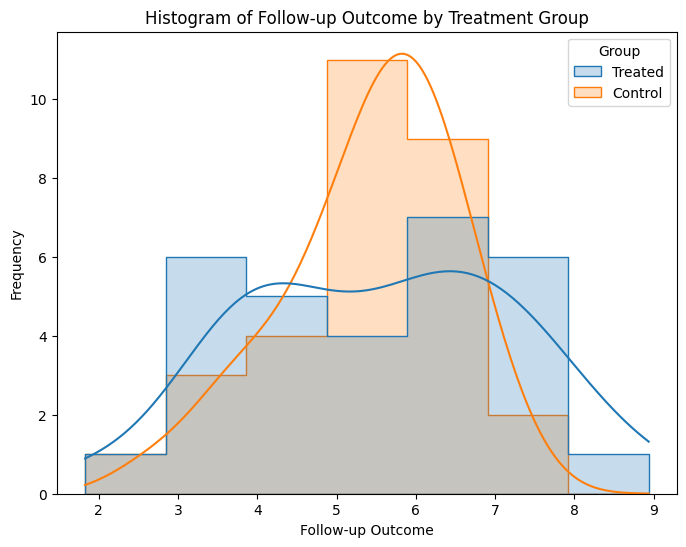

In [5]:
# -------------------------------
# Step 5: Statistical Analysis & Interpretation
# -------------------------------

# Assume:
# - `data` is the full dataset (from Step 1) and contains 'patient_id' and 'followup_outcome'
# - `matched_df` is a DataFrame from Step 3 with columns: 'Treated Patient' and 'Control Patient'

# 1. Extract outcomes for each matched pair.
outcomes_treated = []
outcomes_control = []

for idx, row in matched_df.iterrows():
    treated_id = row["Treated Patient"]
    control_id = row["Control Patient"]
    # Retrieve the follow-up outcome for each matched patient.
    outcome_treated = data.loc[data['patient_id'] == treated_id, 'followup_outcome'].values[0]
    outcome_control = data.loc[data['patient_id'] == control_id, 'followup_outcome'].values[0]
    outcomes_treated.append(outcome_treated)
    outcomes_control.append(outcome_control)

# 2. Perform a paired Wilcoxon Signed-Rank Test.
stat, p_val = wilcoxon(outcomes_treated, outcomes_control)
print("Wilcoxon Signed-Rank Test:")
print("Test Statistic:", stat)
print("p-value:", p_val)

# 3. Permutation Test
def permutation_test(x, y, num_permutations=10000):
    """
    A simple permutation test for paired data.
    x, y: arrays of outcomes (paired).
    Returns the observed mean difference and permutation-based p-value.
    """
    x = np.array(x)
    y = np.array(y)
    differences = x - y
    diff_observed = np.mean(differences)
    
    # Generate distribution of mean differences under the null by randomly flipping signs.
    permuted_diffs = []
    for i in range(num_permutations):
        signs = np.random.choice([-1, 1], size=len(differences))
        permuted_diff = np.mean(differences * signs)
        permuted_diffs.append(permuted_diff)
    permuted_diffs = np.array(permuted_diffs)
    
    # Two-sided p-value: proportion of permuted differences as extreme as the observed.
    p_value = np.mean(np.abs(permuted_diffs) >= np.abs(diff_observed))
    return diff_observed, p_value

diff_obs, p_perm = permutation_test(outcomes_treated, outcomes_control)
print("\nPermutation Test:")
print("Observed Mean Difference (Treated - Control):", diff_obs)
print("Permutation p-value:", p_perm)

# 4. Visualizations
# Create a combined DataFrame for plotting.
plot_df = pd.DataFrame({
    'Group': ['Treated'] * len(outcomes_treated) + ['Control'] * len(outcomes_control),
    'Outcome': outcomes_treated + outcomes_control
})

# Boxplot: Compare the distribution of follow-up outcomes.
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='Outcome', data=plot_df)
plt.title("Boxplot of Follow-up Outcome by Treatment Group")
plt.xlabel("Group")
plt.ylabel("Follow-up Outcome")
plt.show()

# Histogram: Inspect the distribution of outcomes for each group.
plt.figure(figsize=(8, 6))
sns.histplot(data=plot_df, x='Outcome', hue='Group', kde=True, element="step")
plt.title("Histogram of Follow-up Outcome by Treatment Group")
plt.xlabel("Follow-up Outcome")
plt.ylabel("Frequency")
plt.show()

# If you have multiple symptom outcomes and wish to perform multivariate analysis,
# consider methods such as MANOVA or multivariate regression. This example focuses on a single outcome.
